# SAUCIE
*Sparse Autoencoders for Unsupervised Clustering, Imputation, and Embedding*

In [1]:
%matplotlib inline

import glob
import numpy as np
import pandas as pd
import os
import plotting
import tensorflow as tf
import matplotlib.pyplot as plt
import saucie
import saucie_utils as utils

from collections import OrderedDict
from saucie import Saucie
from tensorflow.python import debug as tf_debug
from saucie_utils import DataSet

from run import train

## Model Config

In [2]:
data_path = '/data/krishnan/emt_data/data_raw.mat'
dataset = 'emt_rnaseq'
data = utils.load_dataset(dataset, data_path, colnames='/data/krishnan/emt_data/genes.csv')

/home/krishnan/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Fitting PCA on data with shape: (6770, 28910), may take awhile
Done fitting PCA


In [ ]:
data_path = '/data/krishnan/emt_data/data_raw.npz'
dataset = 'emt_rnaseq'
data = utils.load_dataset(dataset, data_path)
# config_path = 'saucie_models/zika/17-09-26-runs/0/model.config'
# model, config = saucie.load_model_from_config(dataset, config_path)
config = saucie.default_config(dataset)

In [4]:
# config['encoder_layers'] = [20,20]
config['act_fn'] = 'relu'
config['d_act_fn'] = 'relu'
config['emb_dim'] = 10
config['sparse_config'] = utils.SparseLayerConfig(l2_w_lam=np.array([1e-4,1e-4,1e-4],dtype=utils.FLOAT_DTYPE))

In [5]:
print('\n'.join([str(x) for x in config.items()]))

('input_dim', 20)
('encoder_layers', [1024, 512, 256])
('emb_dim', 10)
('act_fn', 'relu')
('d_act_fn', 'relu')
('use_bias', True)
('loss_fn', 'bce')
('opt_method', 'adam')
('lr', 0.001)
('batch_norm', True)
('sparse_config', SparseLayerConfig(id_lam=[0.0, 0.0, 0.0],l1_lam=[0.0, 0.0, 0.0],l1_w_lam=[0.0, 0.0, 0.0],l2_w_lam=[9.999999747378752e-05, 9.999999747378752e-05, 9.999999747378752e-05],l1_b_lam=[0.0, 0.0, 0.0],l2_b_lam=[0.0, 0.0, 0.0]))
('save_path', './saucie_models/emt_rnaseq')


## Training Config

In [6]:
# TRAINING FLAGS
batch_size = 200     # size of batch during training
num_epochs = 70      # number of epochs to train
patience = 5         # number of epochs to train without improvement, early stopping
log_every = 5      # training loss logging frequency
save_every = 20     # checkpointing frequency
tb_graph = True      # logs graph to TensorBoard if True
tb_summs = True      # logs summaries to TensorBoard if True
debug = False        # enable tfdebug
verbose = False      # will log in debug mode if True
gpu_mem = 0.45       # percent of gpu mem to allocate

# PLOTTING FLAGS
thresh = .5          # threshold to binarize id regularized layers
save_plots = False    # saves plots if True

## Run Training

In [44]:
sess.close()
tf.reset_default_graph()

In [7]:
if verbose:
    tf.logging.set_verbosity(tf.logging.DEBUG)
else:
    tf.logging.set_verbosity(tf.logging.INFO)
if debug:
    sess = tf_debug.LocalCLIDebugWrapperSession(sess)
    sess.add_tensor_filter('has_inf_or_nan', tf_debug.has_inf_or_nan)

model = Saucie(**config)
plot_dir = model.save_path + '/plots'
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=gpu_mem)
sess = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))
model.build(sess)

In [9]:
from sklearn.decomposition import PCA

/usr/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


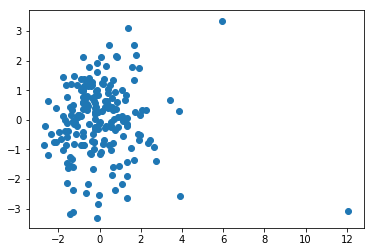

In [13]:
emb = sess.run(model.encoder, feed_dict={model.x_: data.data[:batch_size], model.is_training_: False})

pca = PCA(2)
emb_2d = pca.fit_transform(emb)
plt.scatter(emb_2d[:,0],emb_2d[:,1])

In [ ]:
plot_folder = model.save_path + '/plots'

if not os.path.exists(plot_folder):
    os.makedirs(plot_folder)
save_file = plot_folder + '/embedding.png'

plot_ops = OrderedDict(emb=model.encoder)
plot_ops['cluster_acts'] = tf.get_collection('id_normalized_activations')

subs = np.random.choice(np.arange(len(data.data)), 5000, replace=False)
test_feed_dict = {model.x_: data.data[subs,:],
                  model.is_training_: False}

plot_dict = sess.run(plot_ops, feed_dict=test_feed_dict)

acts = plot_dict['cluster_acts'][0]
clusts = utils.binarize(acts, thresh)
plotting.plot_embedding2D(plot_dict['emb'], clusts, save_file, 'Bottleneck layer embedding')